In [9]:
#Documentation : http://docs.scipy.org/doc/scipy/reference/sparse.html
"""
Sparse matrices can be used in arithmetic operations: they support addition, subtraction, multiplication, division, and matrix power.
Advantages of the CSR format

        efficient arithmetic operations CSR + CSR, CSR * CSR, etc.
        efficient row slicing
        fast matrix vector products
Disadvantages of the CSR format

        slow column slicing operations (consider CSC)
        changes to the sparsity structure are expensive (consider LIL or DOK)
"""
import scipy.sparse as sparse
from scipy.sparse import csr_matrix
from scipy.sparse import lil_matrix
from scipy.sparse import dia_matrix
import scipy.sparse.linalg as spl

import scipy as sc
import scipy.misc
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/home/gnthibault/anaconda3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['size']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


# Signal processing on graph

### Introduction

First, we would like to thank John D Cook for its [short introduction](https://www.johndcook.com/blog/2016/02/09/fourier-transform-of-a-function-on-a-graph/) on Fourier series on graph, and of course [Pierre Vandergheynst](https://scholar.google.ch/citations?user=1p9NOFEAAAAJ&hl=fr), for its interesting courses and its contributions to this field.

### Fourier series

Fourier series properties can be analyzed within various mathenatical framework. One of them is related to the Laplacian operator.

We recall that the Laplacian operator, sometimes written $\nabla \cdot \nabla$, $\nabla^2$ or $\Delta$, where $\nabla$ can be written $\left( \frac{\partial}{\partial x_0}, \frac{\partial}{\partial x_1}, \dots \frac{\partial}{\partial x_{n-1}} \right)$ and the laplacian operator applied to a function $f$ reads $\Delta f = \sum_{i=0}^{n-1} \frac{\partial f}{\partial x_i^2}$.

It is interesting to notice that the trigonometric polynomial that defines the (separable) Fourier series basis elements are eigenfunctions for the laplacian operators over euclidean spaces:

lets define $\delta_{nF}(x) = e^{2 \pi j nFx}$

And
\begin{align}
  \frac{\partial \delta_{nF}}{\partial x} (x) &= \frac{\partial  e^{2 \pi j nFx}}{\partial x} \\
  &= 2 \pi j nF e^{2 \pi j nFx} \\
\end{align}

And
\begin{align}
  \frac{\partial \delta_{nF}}{\partial x^2} (x) &=  -(2\pi nF)^2 e^{2 \pi j nFx} \\
  &= -(2\pi nF)^2 \delta_{nF}\\
  &= \lambda \delta_{nF}
\end{align}

Moreover, eigenfunctions of the laplacian can also be defined for functions on finite domains (Bessel functions for radially symmetric domain like disks and sphere)

## Elements of calculus on graphs

### Definitions, operators
Graphs are not euclidean spaces, lets define some calculus elements before jumping on more advanced stuff:

| Name | ........................ Definition ........................ | Comment |
|:----:|:----------:|:-------:|
| Graph | $\mathcal{G} = (\mathcal{V}, \mathcal{E})$ | |
| Vertices | $\mathcal{V} = {1,\dots, n}$ | n is the cardinality of the vertices |
| Vertex weights | $b_i > 0 \forall i \in \mathcal{V}$| |
| Edges | $\mathcal{E} \subseteq \mathcal{V} \times \mathcal{V}$ | |
| Edge weights | $a_{ij} \geq 0 \quad \forall \quad (i,j) \quad \in \mathcal{E}$ | |
| Vertex field | $L^2(\mathcal{V}) = {f : \mathcal{V} \rightarrow \mathbb{R}^n}$ | Functional space of all $L^2$-integrable functions <br> sampled over the graph (1 real value per vertex) |
| graph function | $f = (f_1, \dots, f_n)$ | One element of $L^2(\mathcal{V})$ presented above  |
| Inner product | $\langle f,g \rangle_{L^2(\mathcal{V})} = \sum_{i \in \mathcal{V}} b_i f_i g_i$ | Allows to define a functional Hilbert <br> space of graph-based functions |
| Gradient operator | $(\nabla f)_{ij} = \sqrt{a_{ij}}(f_i-f_j)$ | $\nabla : L^2(\mathcal{V}) \rightarrow L^2(\mathcal{E})$ |
| Divergence operator | $(div F)_{i} = \frac{1}{b_i} \sum_{j:(i,j) \in \mathcal{E}} \sqrt{a_{ij}}(F_{ij}-F_{ji})$ |$div : L^2(\mathcal{E}) \rightarrow L^2(\mathcal{V})$ |
| Gradient Adjoint |$\nabla^{\star}F = -div F$ | $\langle F,\nabla f \rangle_{L^2(\mathcal{E})} = \langle \nabla^{\star}F, f \rangle_{L^2(\mathcal{V})} = \langle -div F, f \rangle_{L^2(\mathcal{V})}$ |
| Laplacian operator | $(\Delta F)_{i} = \frac{1}{b_i} \sum_{j:(i,j) \in \mathcal{E}} a_{ij}(f_i-f_j)$ | $\Delta : L^2(\mathcal{V}) \rightarrow L^2(\mathcal{V})$, this one is the $D-A$ |
| Weight matrix | $A = (a_{ij})$ | |
| Degree matrix | $D = diag(\sum_{j\neq i}a_{ij})$ | |
| Unnormalized Laplacian | $\Delta = D - A$ | |
| Unnormalized Laplacian | $\Delta = I - D^{-\frac{1}{2}} A D^{-\frac{1}{2}}$ | |
| Random walk Laplacian | $\Delta = I - D^{-1} A $ | |

In [70]:
#lets define some utilities for testing on random/symmetric sparse matrices

# define graph adjacency matrix as a random csr matrix
def gen_random_spm(size):
    return sparse.rand(size[0], size[1], density=0.9, format='csr', dtype=np.float32, random_state=None)

def gen_random_graph(size):
    A = gen_random_spm((size,size))
    # Now make it symmetric
    return A+A.T-sparse.diags(A.diagonal())

# define graph adjacency matrix as a small symmetric csr matrix
def gen_small_graph():
    weight=[1,1,2]
    rowIdx=[1,2,0]
    colIdx=[0,1,2]
    A = csr_matrix((np.array(weight), (np.array(rowIdx), np.array(colIdx))),dtype=np.float32)
    #Build a symmetric matrix
    return A+A.T+A.diagonal()

In [76]:
# lets define some operators, term by term and/or with a matrix:
def grad(G,f):
    """-G is the graph adjacency matrix
       -f is the function defined on this graph
       Output has the dimension of the adjacency matrix
       Elementwise version
    """
    g = lil_matrix(G.shape)
    #iterate over all edges, row_index is i, col_idx is j
    for row_idx, col_idx, weight in zip(*G.nonzero(), G.data):
        g[row_idx, col_idx] = np.sqrt(weight)*(f[row_idx]-f[col_idx])
    return g

# lets define some operators, term by term and/or with a matrix:
def div(G,F,b=None):
    """-G is the graph adjacency matrix
       -F is the gradient of function f on this graph
       -b is the optional vertex_weight
       Output is 1D and has its size equal to the cardinality of the vertices
       Elementwise version
    """
    # If b is not provided, assume all vertices have weight 1
    if b is None:
        v_weight = lambda idx: 1
    else:
        v_weight = lambda idx: 1/b[idx]
        
    div = np.zeros(G.shape[0])
    for row_idx in range(div.size):
        row = G.getrow(row_idx)
        d = 0
        for _, col_idx, weight in zip(*row.nonzero(), row.data):
            d += np.sqrt(weight)*(F[row_idx, col_idx]-F[col_idx, row_idx])
        div[row_idx] = v_weight(row_idx)*d
    return div

In [77]:
# Now define those operators as linear operators

def get_edge_grad_matrix(G):
    """-G is the graph adjacency matrix
    Returns the matrix that takes a function f, valued of the the network and returns the gradient
    (as a linear index (0,0) (0,1) (0,2)... (1,0) (1,1) (1.2)...
    """
    grad_mat = lil_matrix((np.prod(G.shape), G.shape[0]), dtype=np.float32)
    #print('G shape is {} gradmat shape is {}'.format(G.shape,grad_mat.shape))
    for i in range(G.shape[0]):
        for j in range(G.shape[1]):
            weight = np.sqrt(G[i,j])
            grad_mat[i*G.shape[1]+j,i]=0
            grad_mat[i*G.shape[1]+j,j]=0
            grad_mat[i*G.shape[1]+j,i]+=weight
            grad_mat[i*G.shape[1]+j,j]-=weight
    return grad_mat

def grad_with_matrix(G,f):
    """-G is the graph adjacency matrix
       -f is the function defined on this graph
       Output has the dimension of the adjacency matrix
       Elementwise version
    """
    return get_edge_grad_matrix(G).dot(csr_matrix(f.reshape(f.size,1))).tolil().reshape(G.shape)

def div_with_matrix(G,F,b=None):
    """-G is the graph adjacency matrix
       -F is the gradient of function f on this graph
       -b is the optional vertex_weight
       Output is 1D and has its size equal to the cardinality of the vertices
       Elementwise version
    """
    return (-get_edge_grad_matrix(G).T).dot(F.reshape(np.prod(G.shape)))

In [84]:
# check if both grad give the same result:
size = 20
G1 = gen_random_graph(size)
f1 = np.random.rand(size)
grad1 = grad(G1, f1)
gradm1 = grad_with_matrix(G1, f1)
assert(np.allclose(grad1.todense(), gradm1.todense()))

Check the following assumption, for a given linear operator A, and its transpose B, where we cannot explicitly obtain $A^t$ neither $B^t$:

\begin{align*}
    xA^t A y &= x^tBAy \\
    x^t \cdot (A^tA y) &= x^t \cdot (BAy) \\
    (x^tA^t) \cdot (A y) &= (x^tB) \cdot (Ay) \\
    (Ax)^t \cdot (Ay) &= (B^tx) \cdot (Ay)
\end{align*}

By comparing $a = x^t \cdot (BAy)$ and $b = (Ax)^t \cdot (Ay)$

In [97]:
# check if grad and div are transpose of each other
f1 = np.random.rand(size)
f2 = np.random.rand(size)
a = f1.dot(-div(G1, grad(G1, f2)))
b = np.multiply(grad(G1, f1), grad(G1, f2)).sum()
assert(np.allclose(a,b))

0.35993452443399326

### Studying graph thanks to those operators

It is interesting to notice that the concept of smoothness/regularity can be extended to graph structured data as well as:

smoothness($f$) =
\begin{align}
  & \quad \langle f, \Delta f \rangle_{L^2(\mathcal{V})} \\
  = &\sum_{(i,j) \in \mathcal{E} \; \text{s.t} \; i\neq j} (f_i-f_j)^2 \\
  \geq & \qquad 0
\end{align}

### Fourier series on graph

Following the definition seen in the previous section, we can see that on cane define eigenfunctions of laplacian operator on various domain including graph, for instance in our case, where we consider our laplacian operator $L$ as: $L=D^{-\frac{1}{2}}AD^{-\frac{1}{2}}$ where $A$ is the adjacency matrix and $D$ is the degree matrix of the graph.

Hopefully, in an undirected graph, $L$ is a symmetric positive semi definite matrix, hence is diagonalizable in an orthonornmal basis. A function that is defined by a set of values, one per node can then be analyzed over this graph, using eigenvectors of the graph ordered by the norm of their corresponding eigenvalues.

On can then consider that projection of the function over the lower eigenvectors corresponds to low "frequencies", and conversely, the high "frequencies" are obtained when projecting the function over the highest eigenvalues


/home/gnthibault/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  


Text(0.5,1,'Initial image')

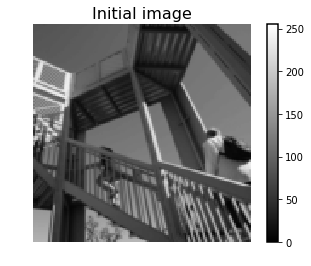

In [2]:
# Import an image, and downsize it in order to make the problem numerically tractable
im = sc.misc.imresize(sc.misc.ascent(),size=(128,128))
im = im.astype(np.float32)
plt.imshow(im, interpolation='nearest', cmap=cm.gray, vmin=0, vmax=255)
figsize(8,8)
plt.axis("off")
colorbar()       # displays the color bar close to the image
title('Initial image')

In [5]:
#Threshold: valued used to forbid disconnected nodes in the graph of the image
thresh= 1e-4

#Sigma of the gaussian distance metric
sigma = 2
sigmaSquare = sigma**2

#Size of the stencil
stenSize = 4

#will contain the value of the edges
data=[]
rowIdx=[]
colIdx=[]

"""
Now we are going to fill the graph matrix, neglecting small terms.
Distance are actually computed twice, this can be optimized
"""

for idxI in range(im.shape[0]):
  for idxJ in range(im.shape[1]):
    curPixIdx=idxI+im.shape[0]*idxJ
    for stenX in range(-stenSize,stenSize+1):
      for stenY in range(-stenSize,stenSize+1):
        stenIdxX = idxI+stenX
        stenIdxY = idxJ+stenY
        destPixIdx = stenIdxX+im.shape[0]*stenIdxY
        if (stenIdxX>=0)and(stenIdxX<im.shape[0])and\
          (stenIdxY>=0)and(stenIdxY<im.shape[1])and\
          ((stenIdxX!=idxI)and(stenIdxY!=idxJ)):
          dist = np.exp(-np.linalg.norm(im[idxI,idxJ]-im[stenIdxX,stenIdxY])**2/(2*sigmaSquare))
          dist=max(thresh,dist)
          data.append(dist)
          rowIdx.append(curPixIdx)
          colIdx.append(destPixIdx)

"""
   Practical implementation using scipy support for sparse matrices, The compressed sparse row (CSR) format
   represents a matrix M by three (one-dimensional) arrays, that respectively contain:
      -nonzero values
      -the extents of rows
      -column indices
    This format allows fast row access and matrix-vector multiplications (Mx)
"""
A = csr_matrix((np.array(data), (np.array(rowIdx), np.array(colIdx))), dtype=np.float32)

#Now the diagonal matrix
D = dia_matrix((np.array(A.sum(axis=1)),0),shape=A.shape)

#We can define the laplacian: L = D^-0.5 A D^-0.5
L = D.power(-0.5)*A*D.power(-0.5)

In [8]:
"""
Compute the eigendecomposition of the laplacian of the graph
"""

# Get the first 100 eigenvalues of L, a symmetric positive definite matrix
# See http://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.linalg.eigsh.html and
# http://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.sparse.linalg.svds.html
[w,X] = spl.eigsh(L, k=100) #size is now [imsize,nbcomponent]

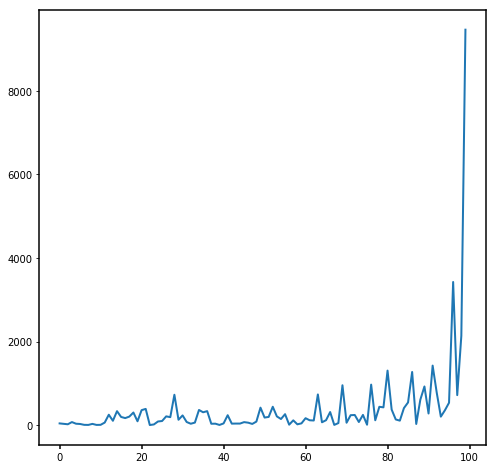

In [9]:
#Show the spectrum of the image, i.e its expression in the basis made of the first lapacian eigenvectors
spectrum = np.abs(np.dot(X.T,im.reshape(im.size)))
plt.plot(spectrum)

/home/gnthibault/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


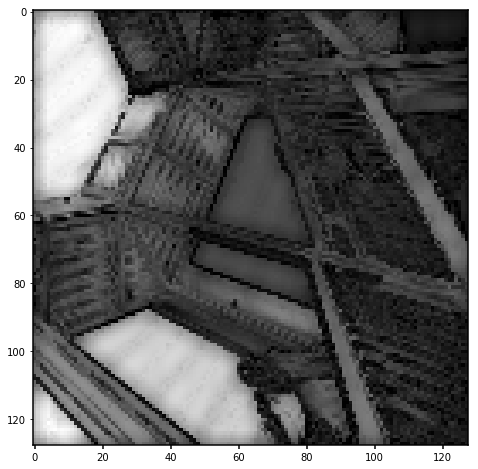

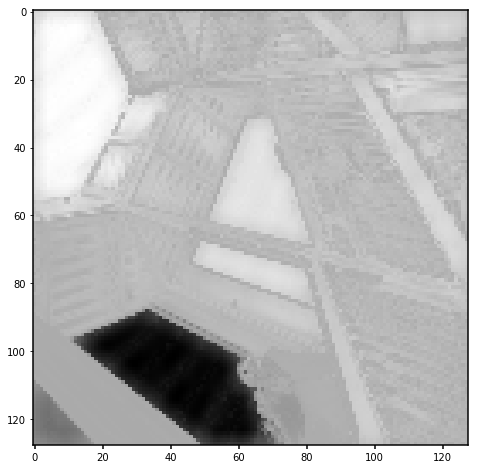

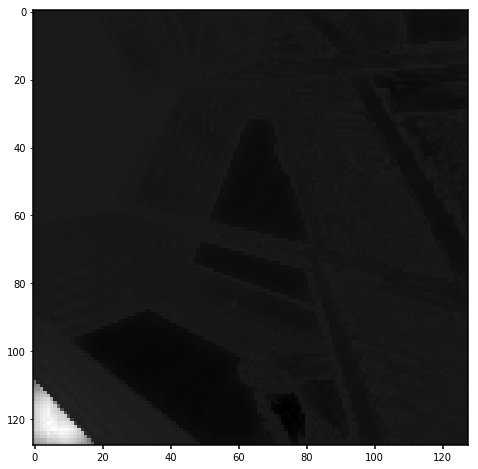

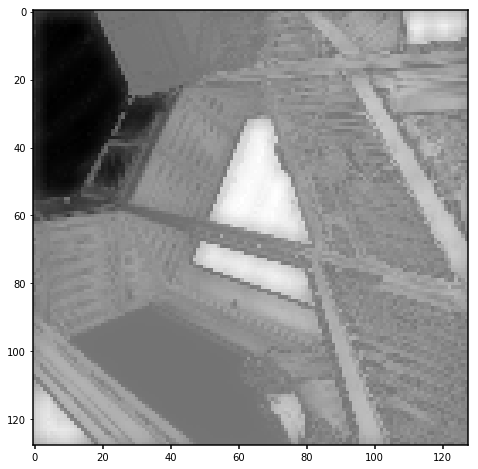

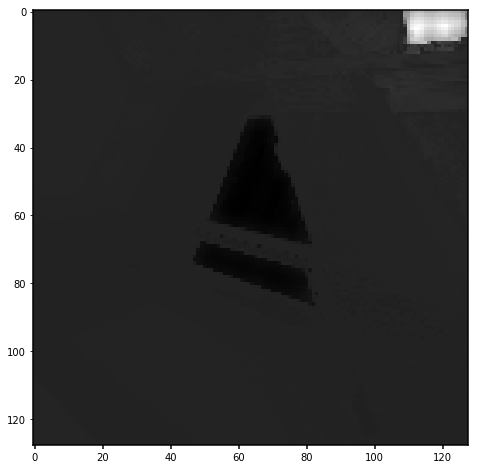

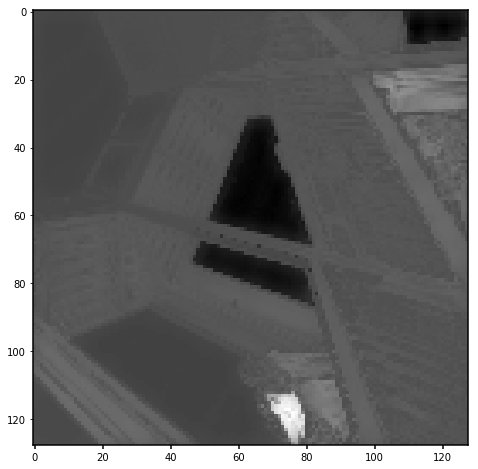

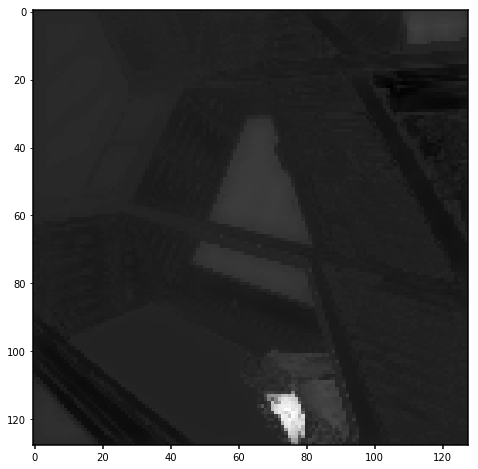

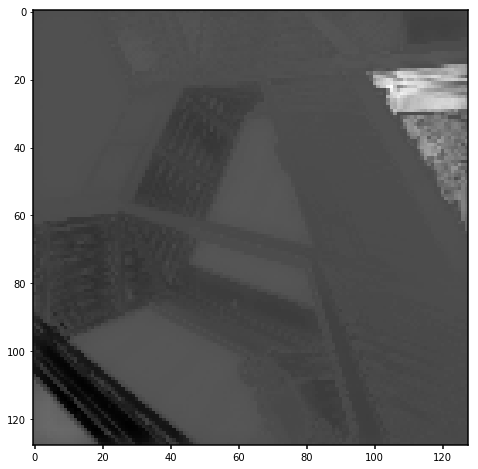

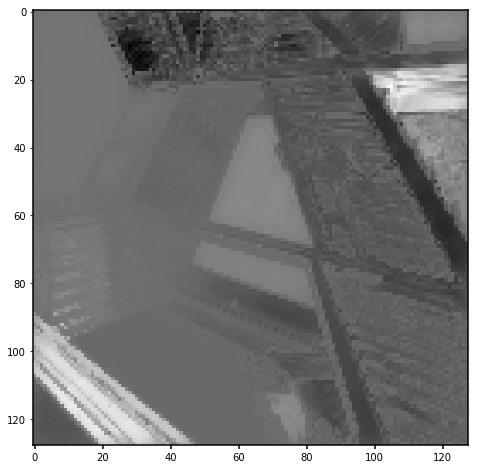

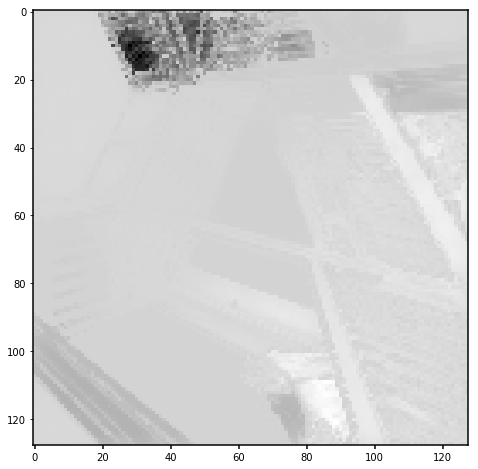

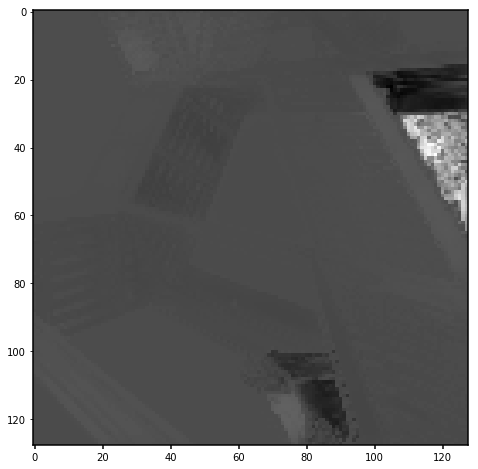

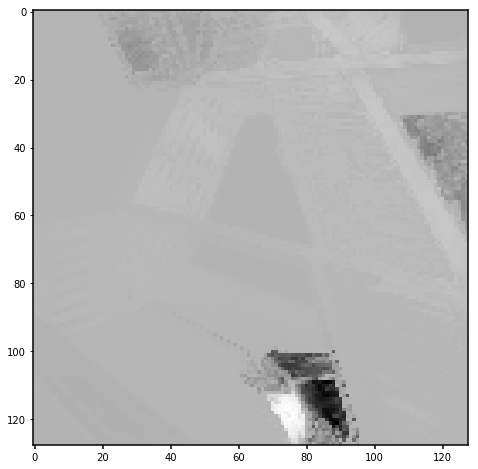

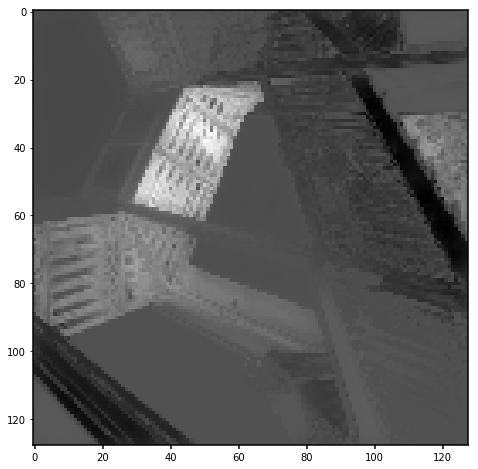

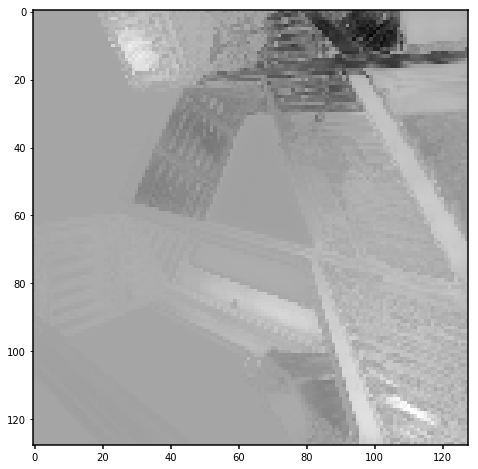

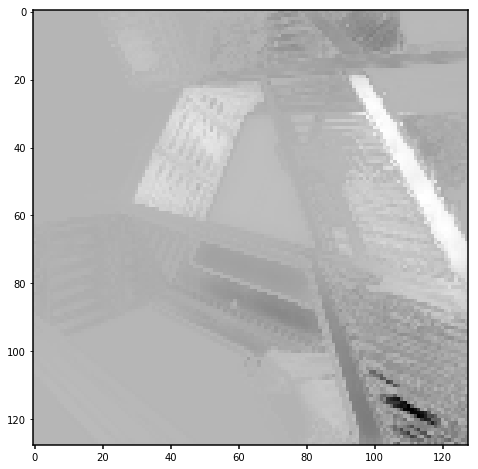

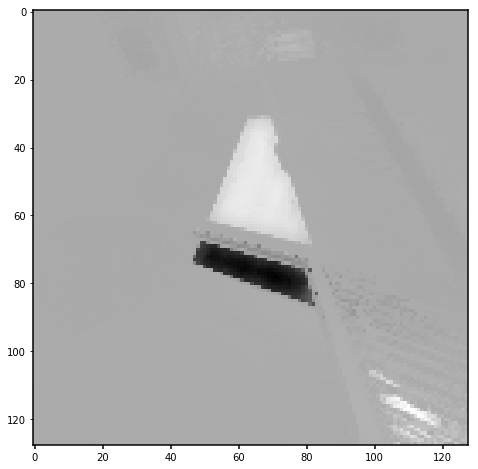

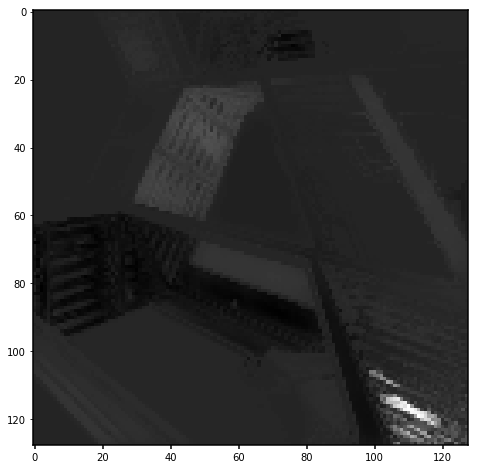

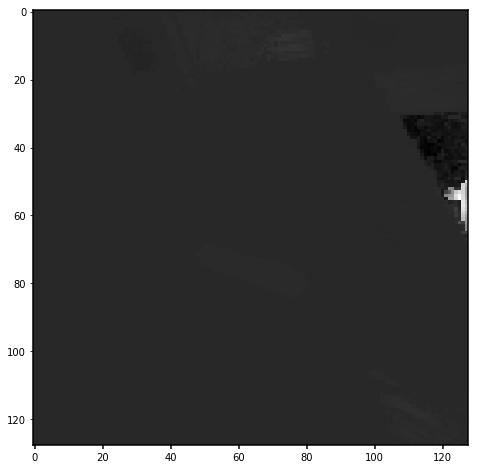

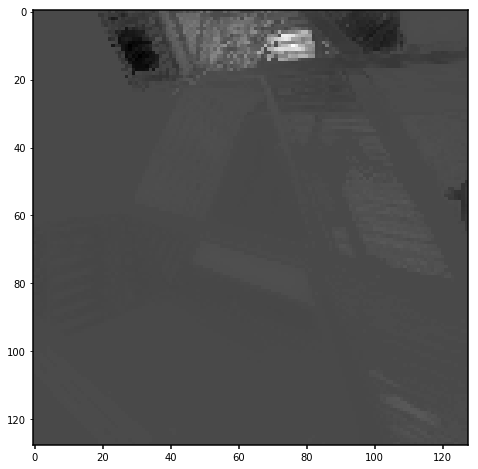

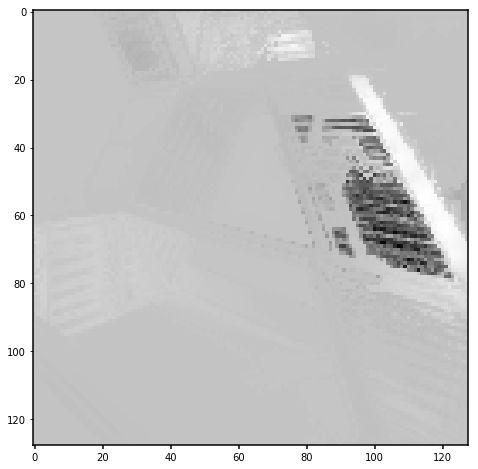

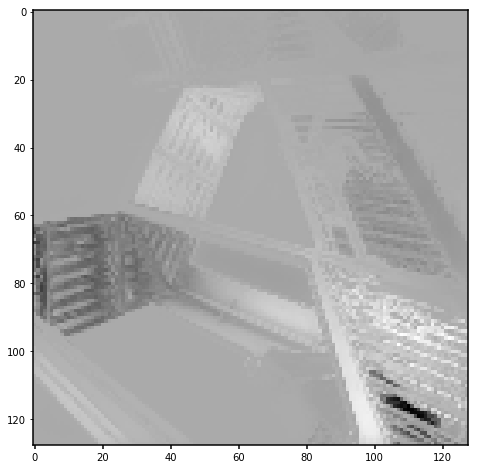

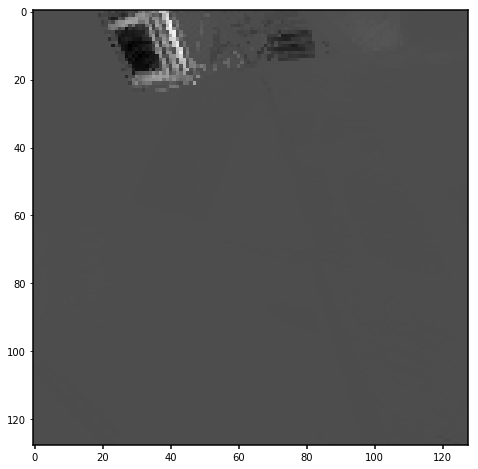

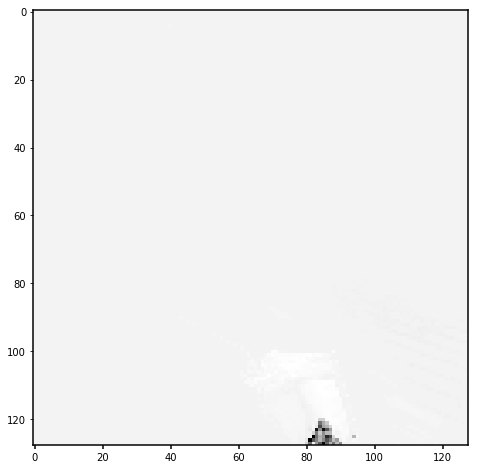

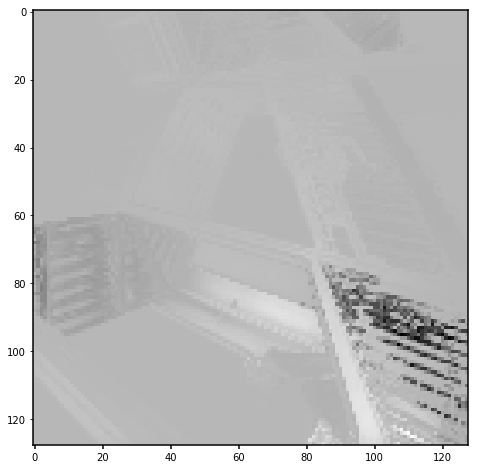

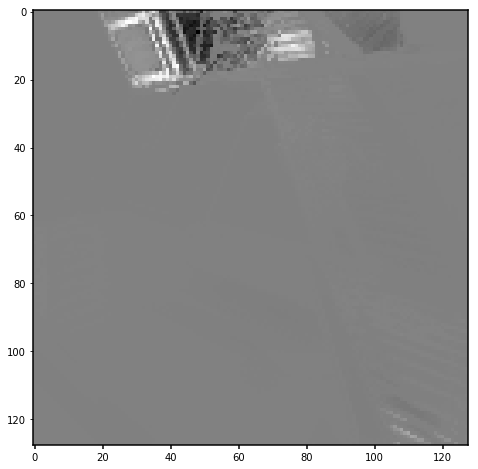

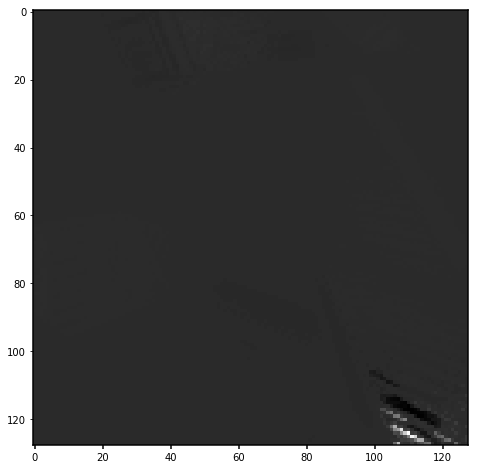

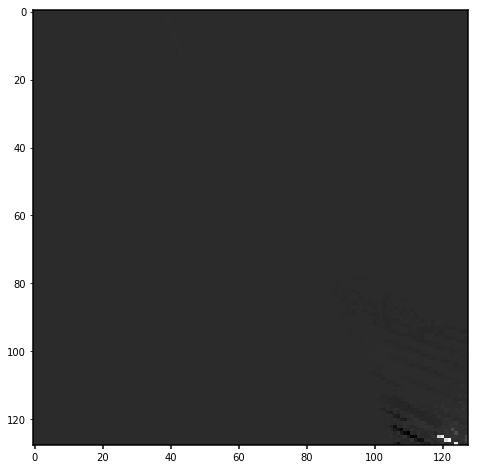

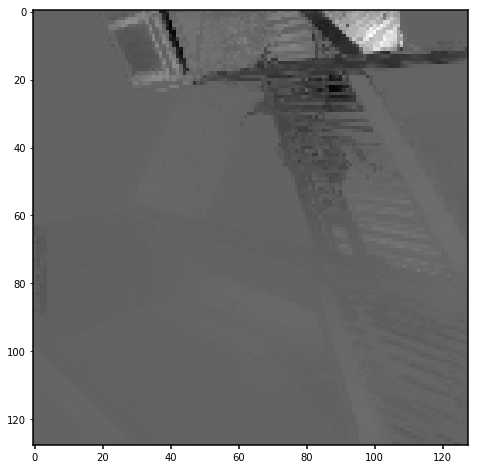

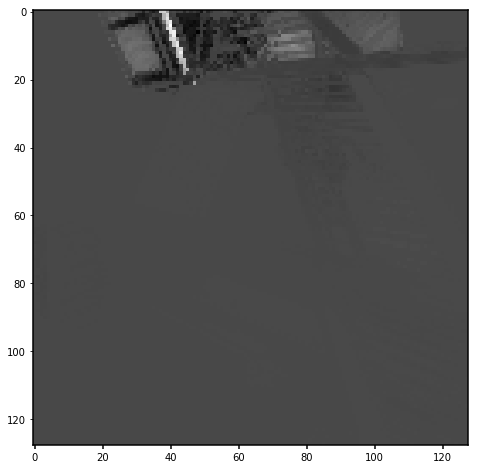

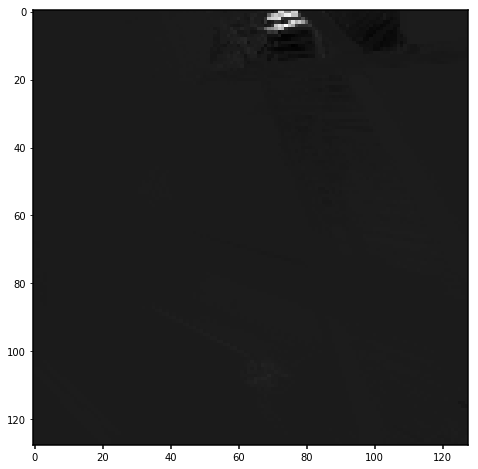

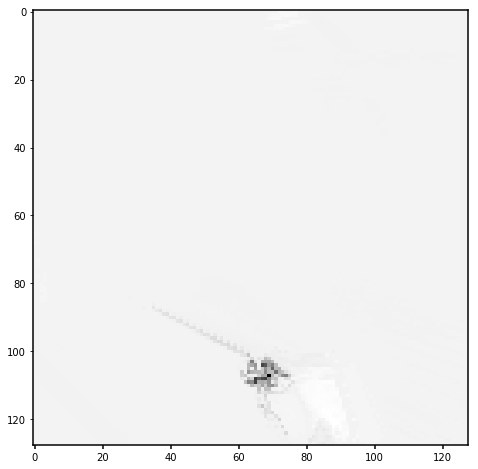

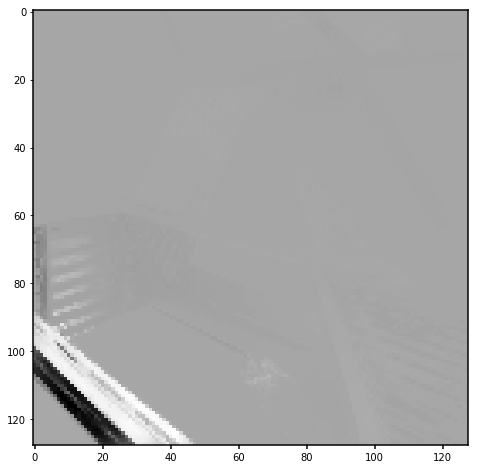

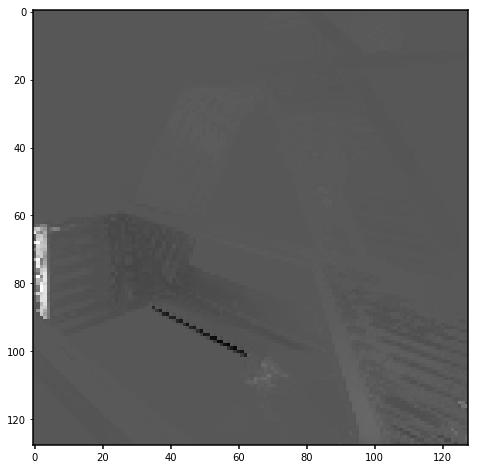

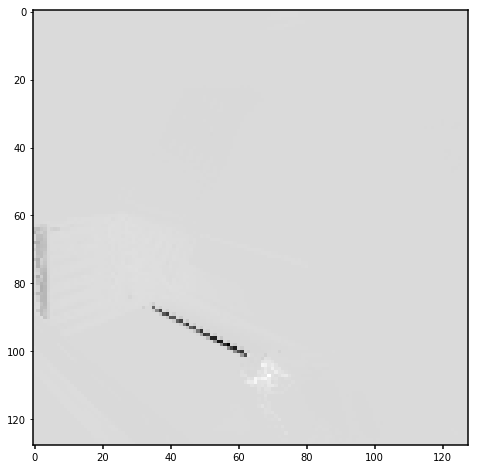

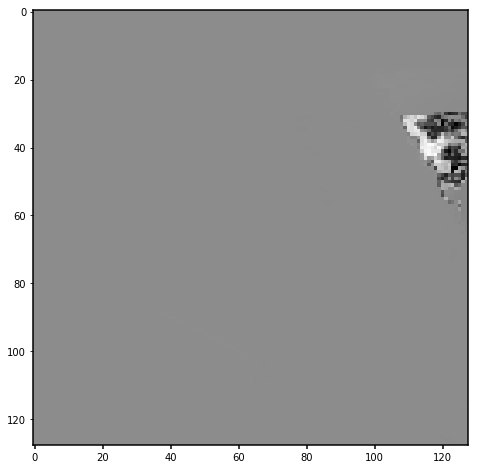

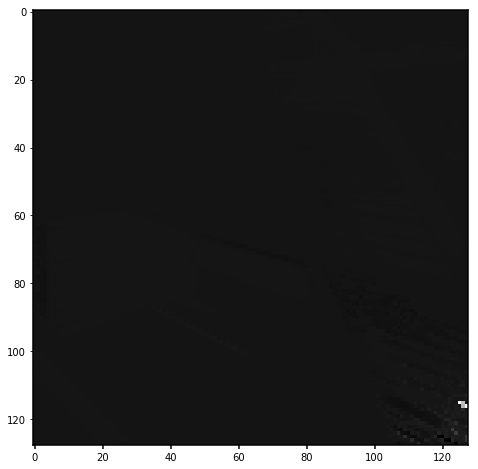

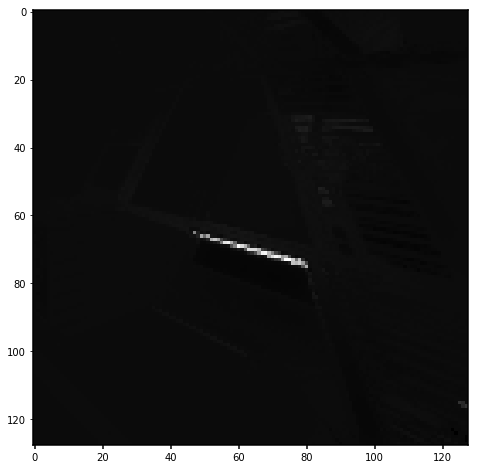

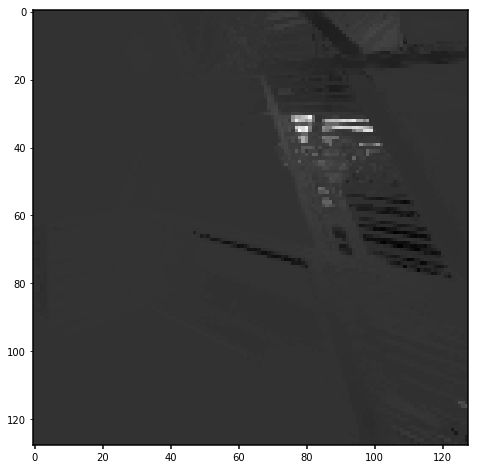

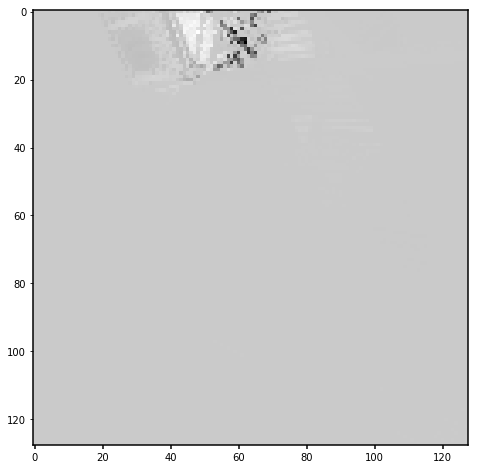

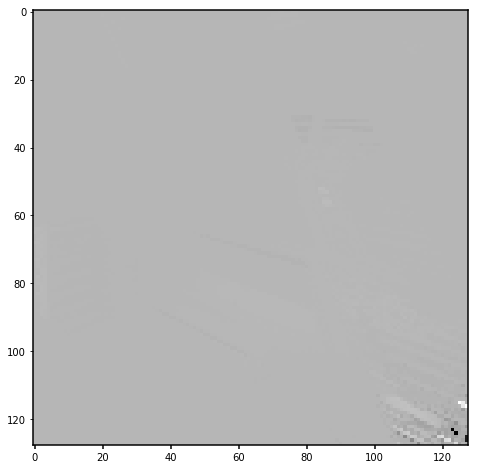

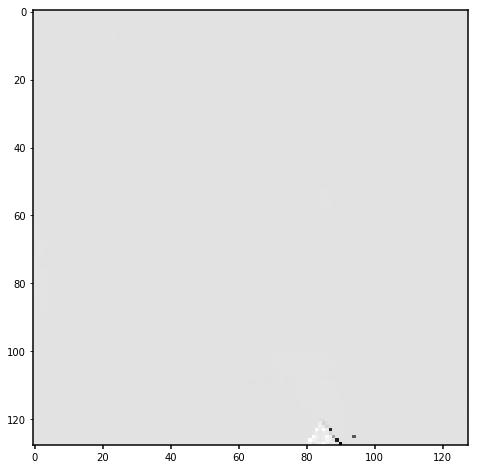

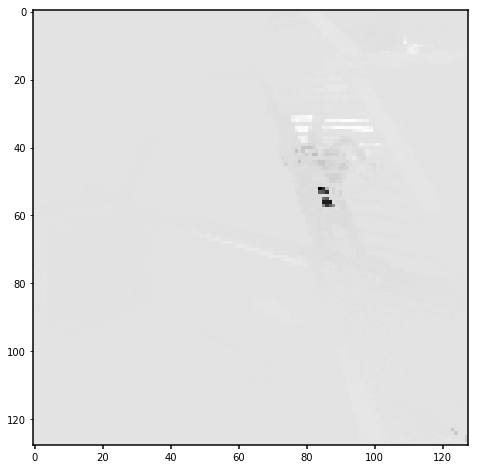

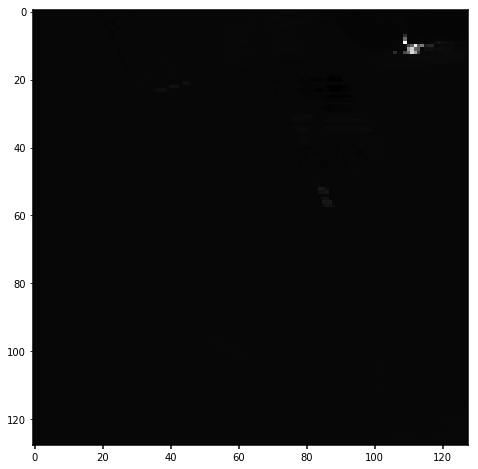

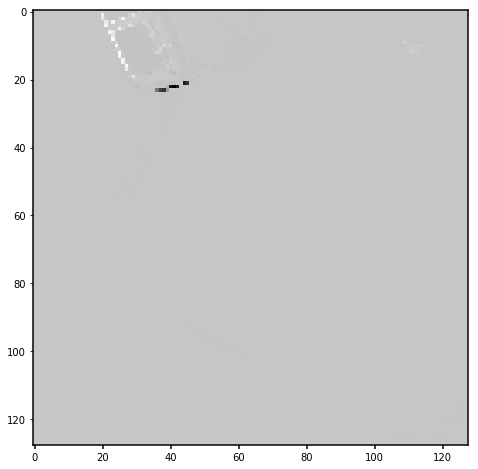

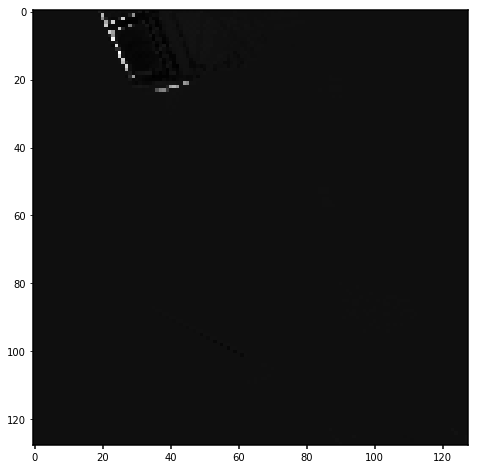

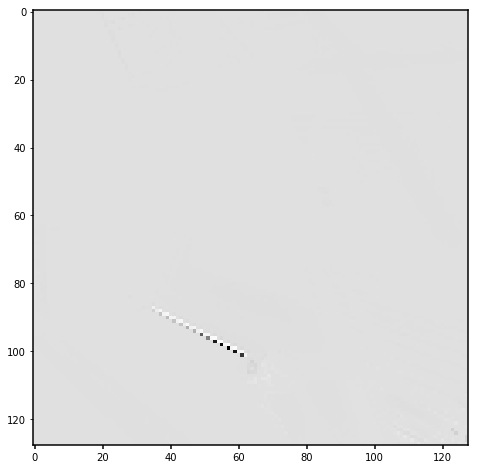

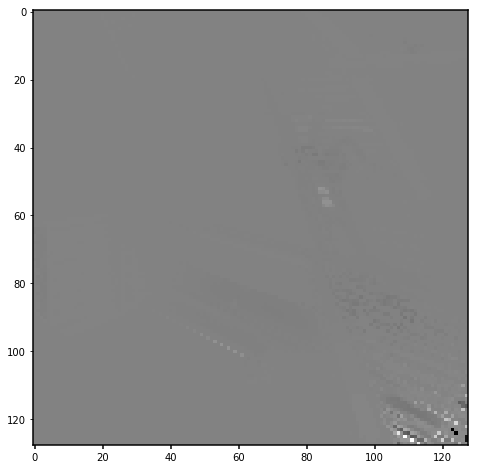

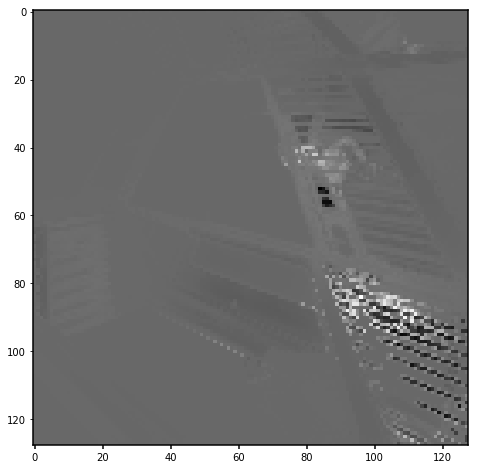

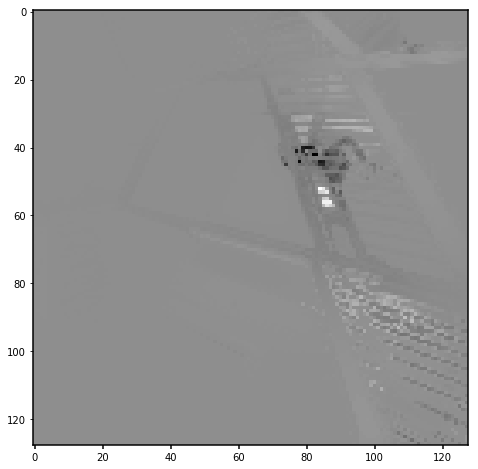

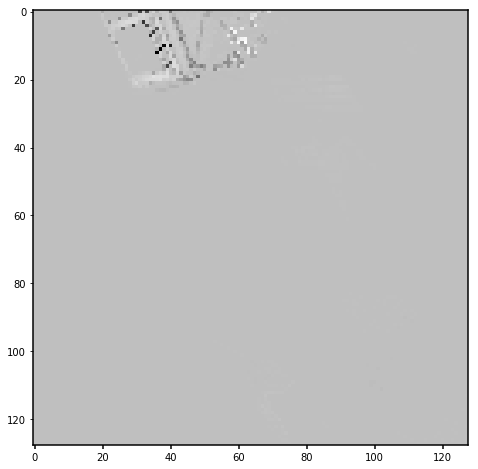

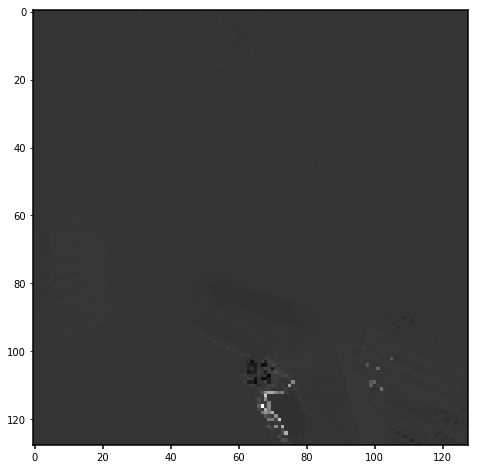

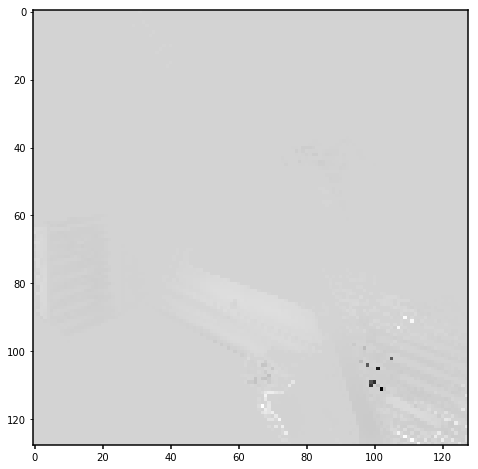

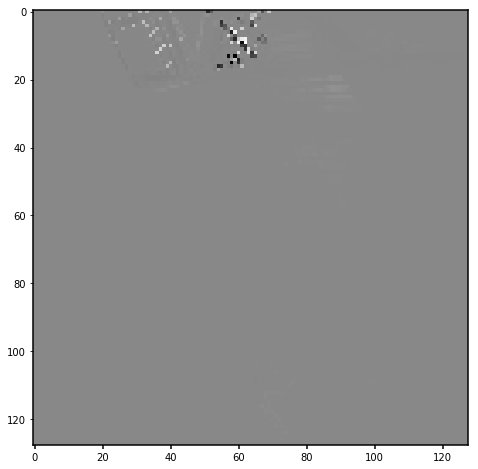

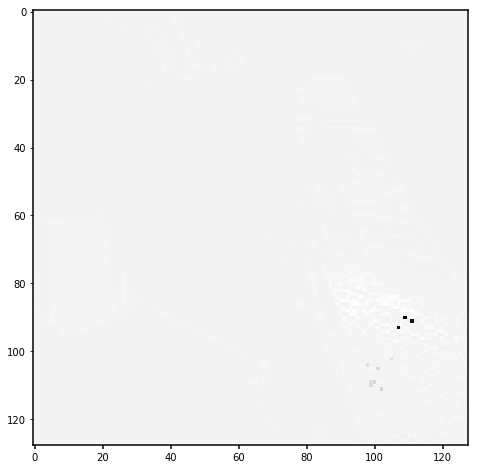

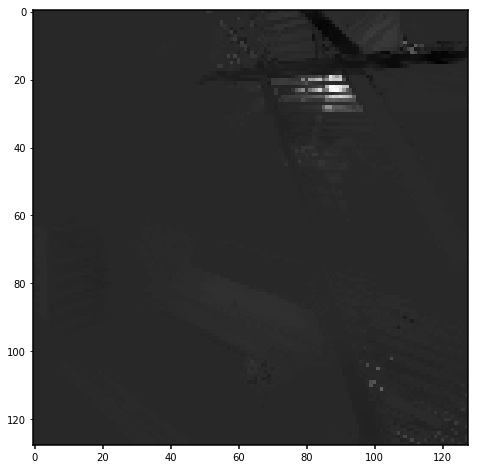

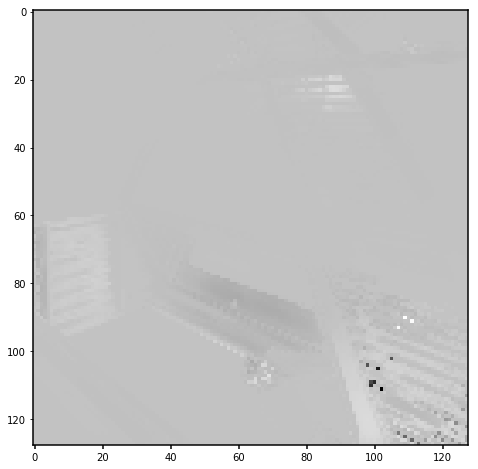

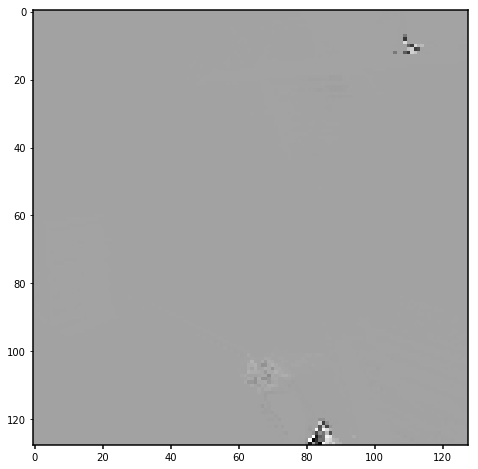

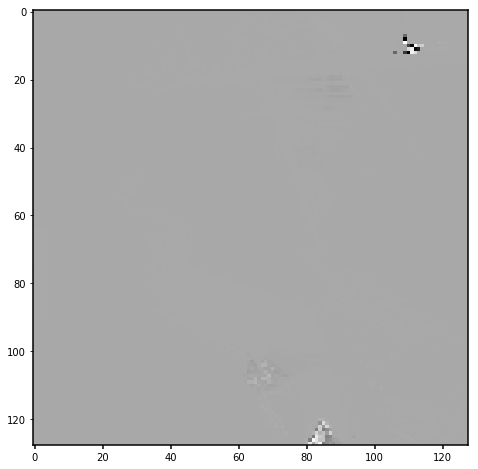

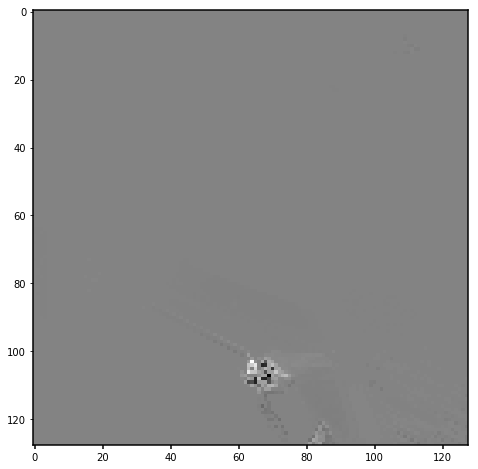

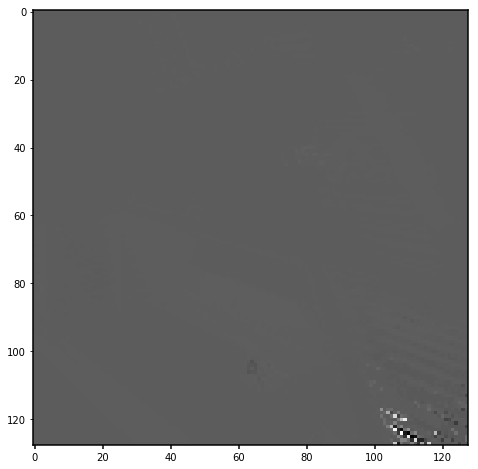

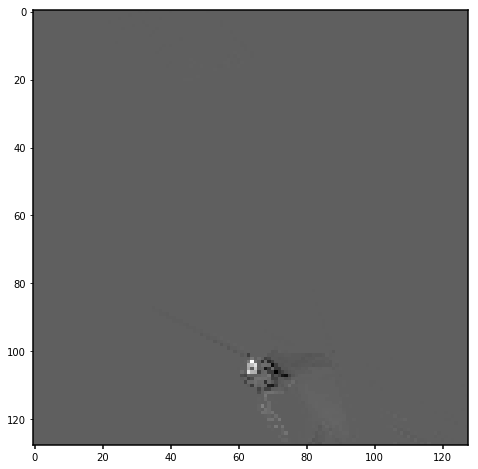

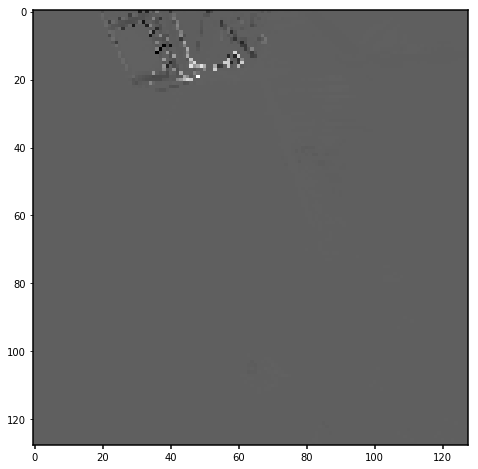

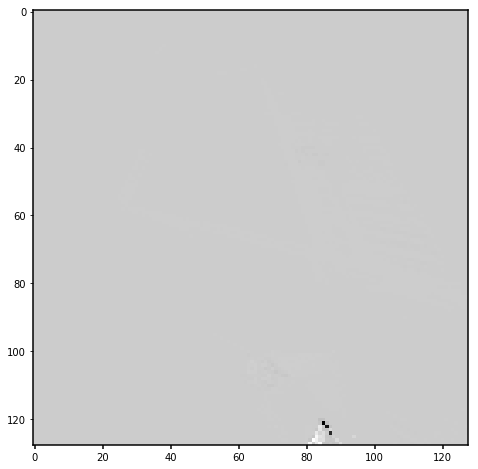

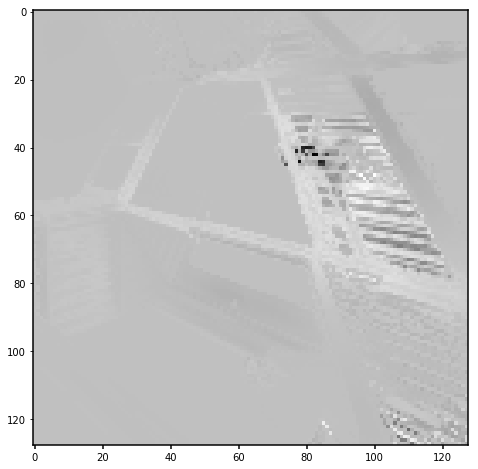

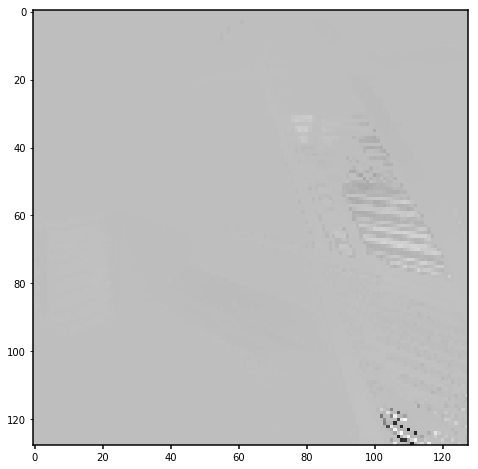

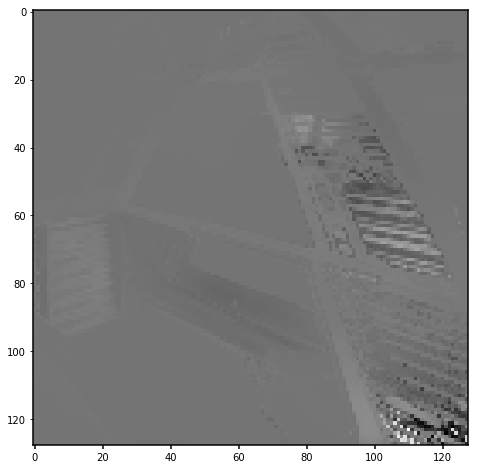

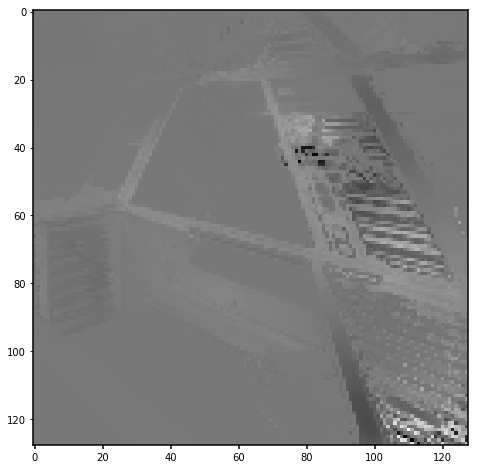

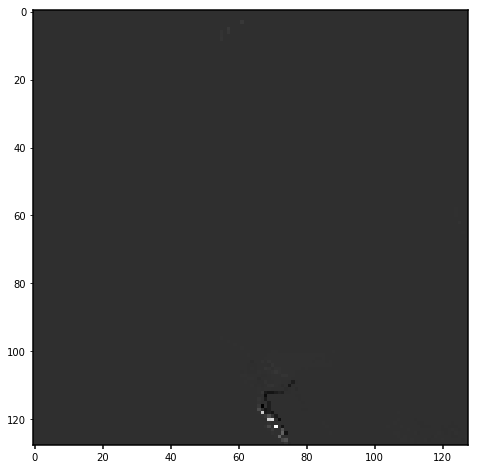

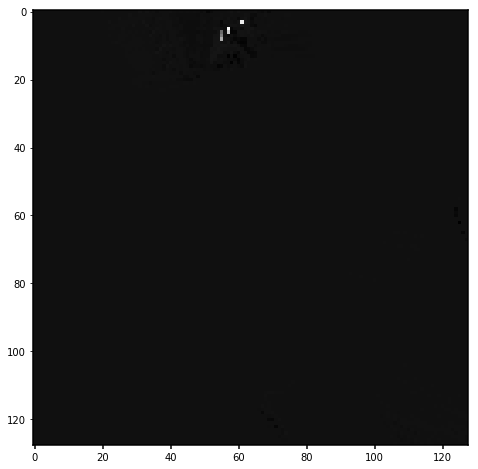

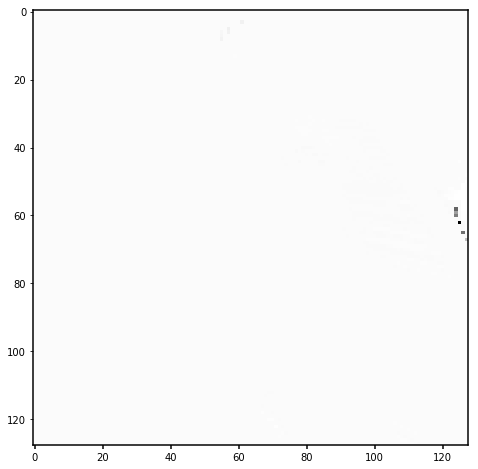

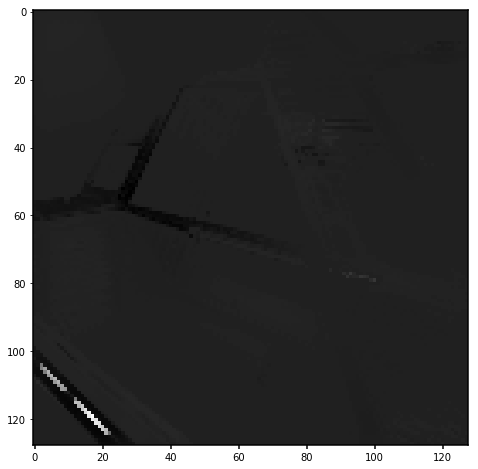

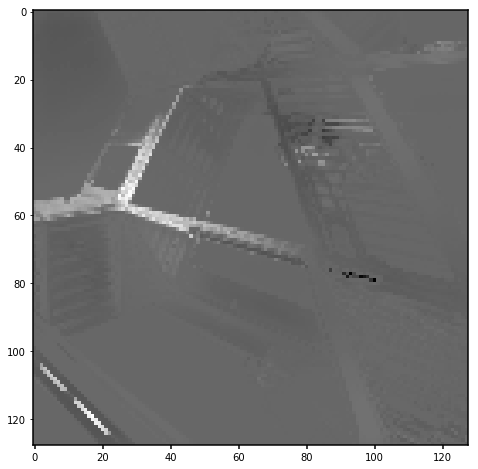

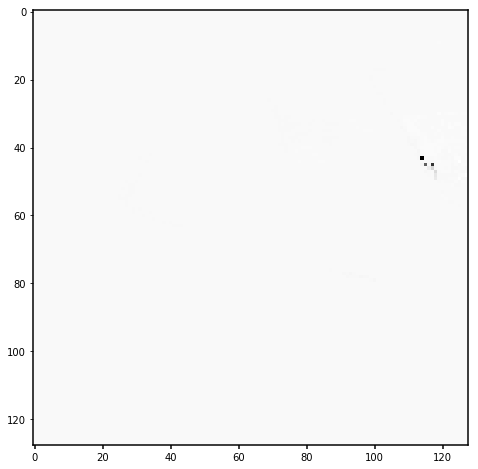

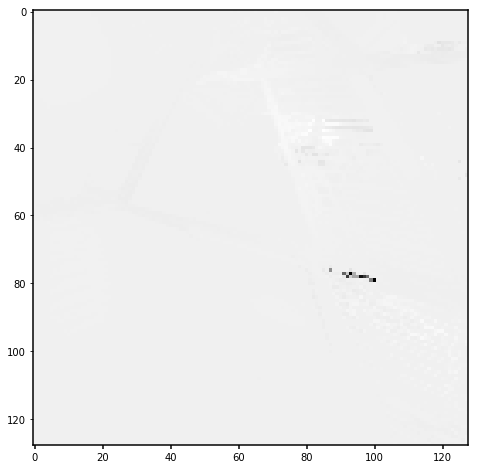

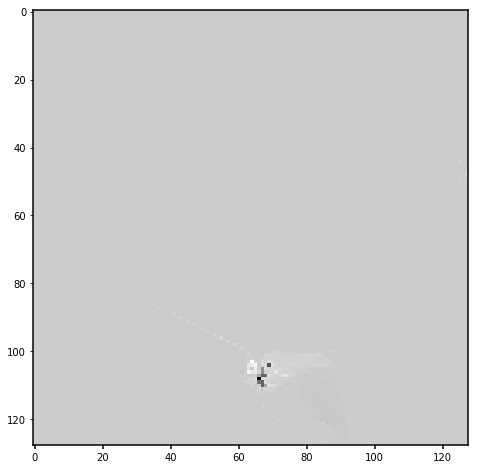

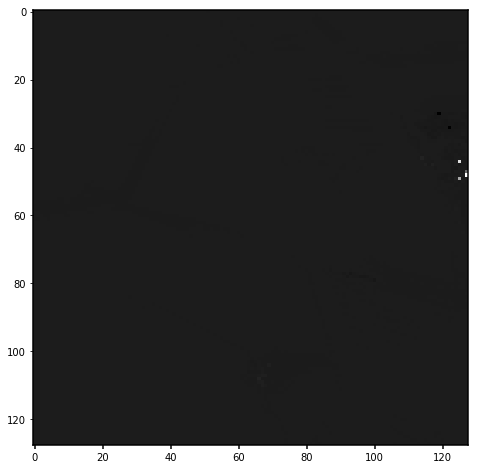

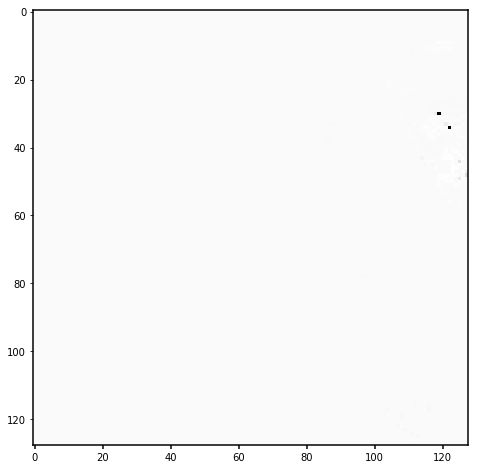

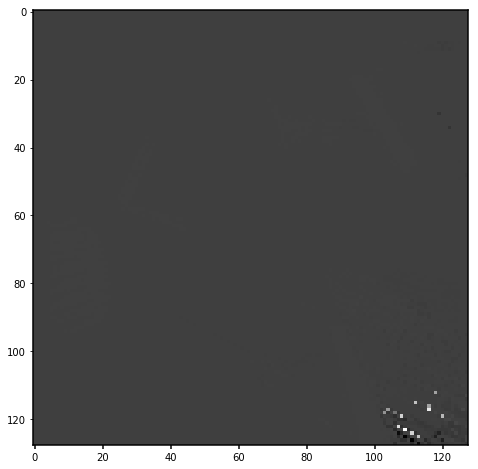

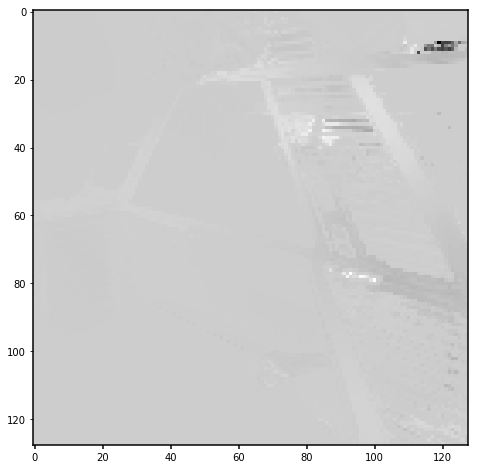

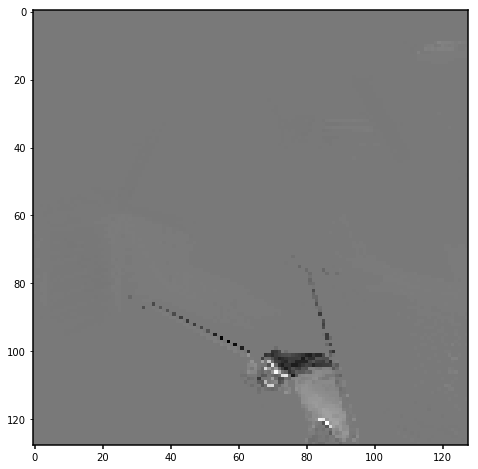

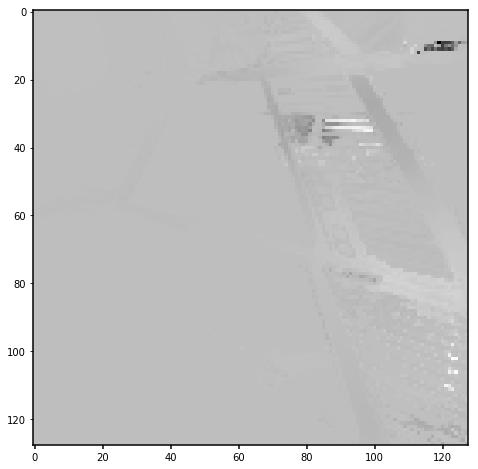

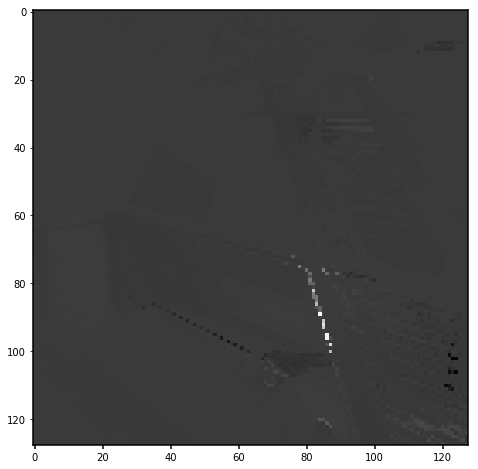

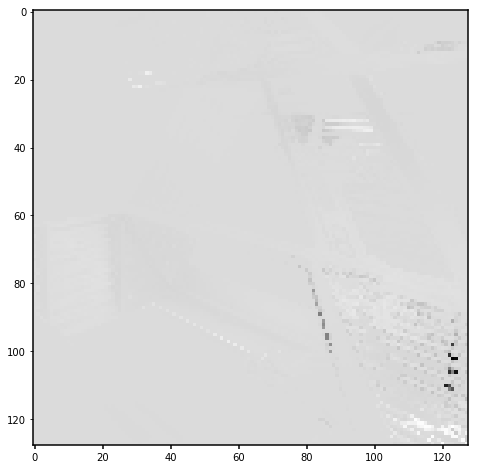

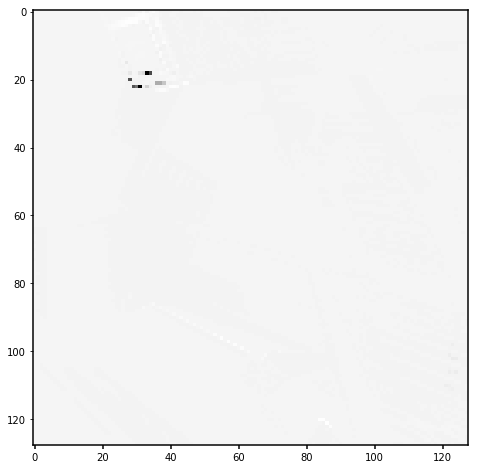

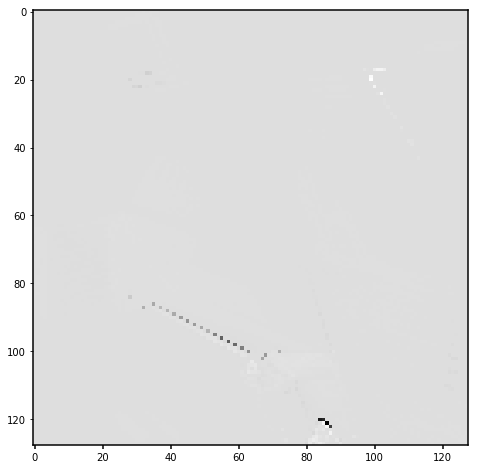

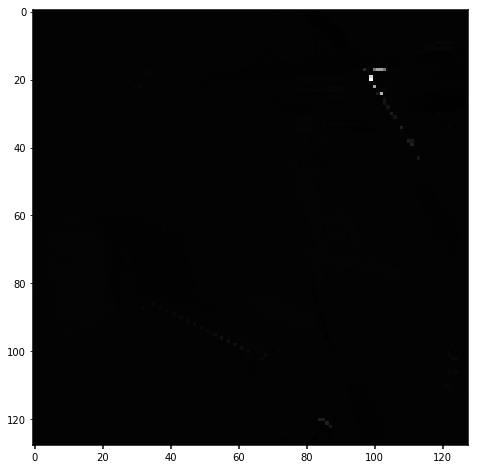

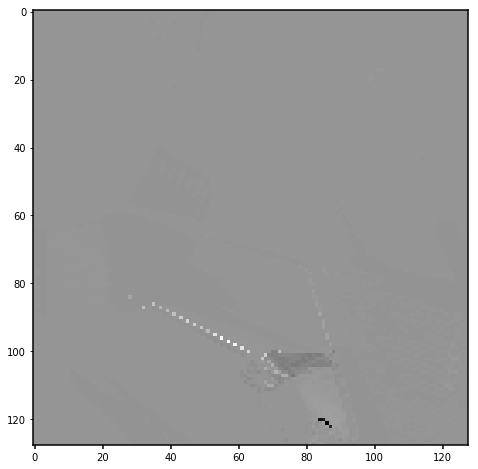

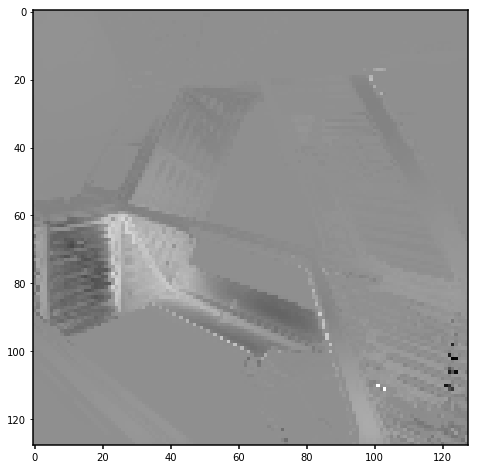

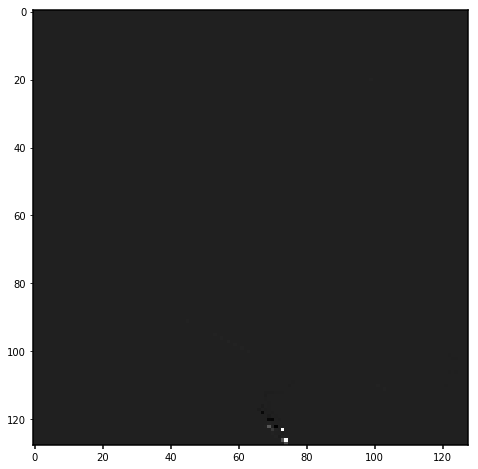

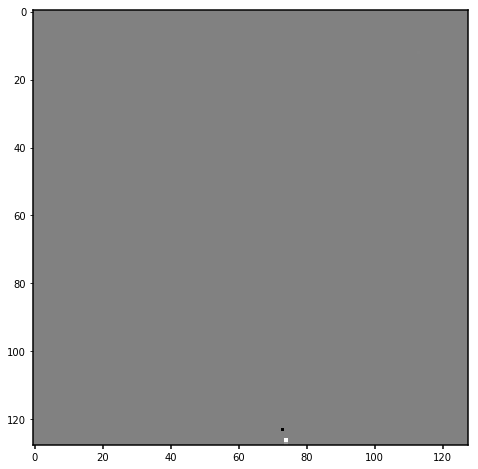

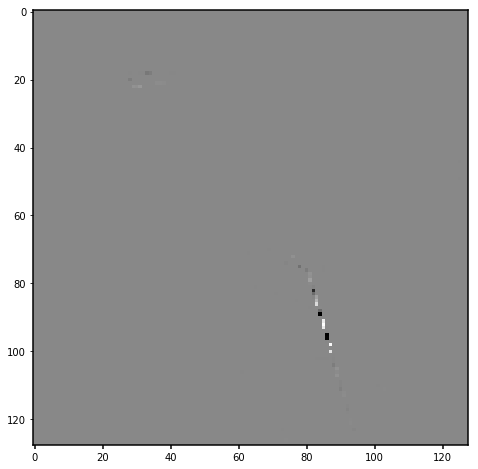

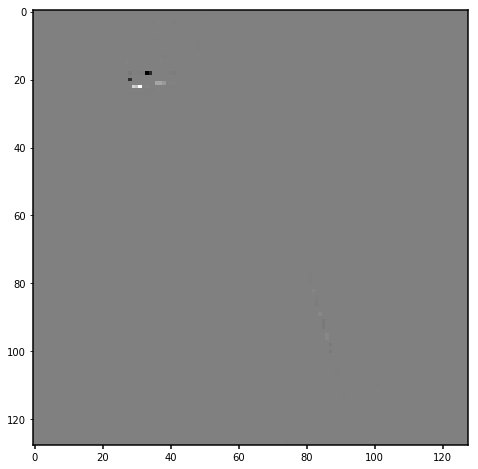

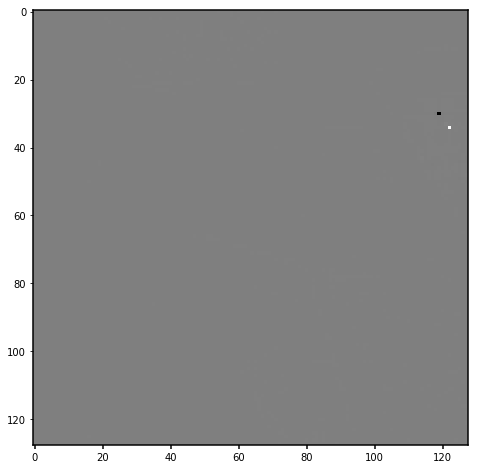

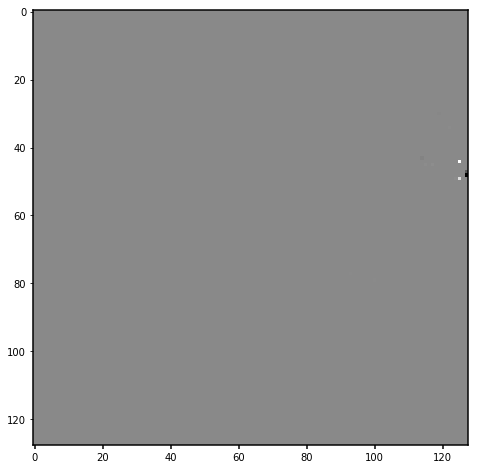

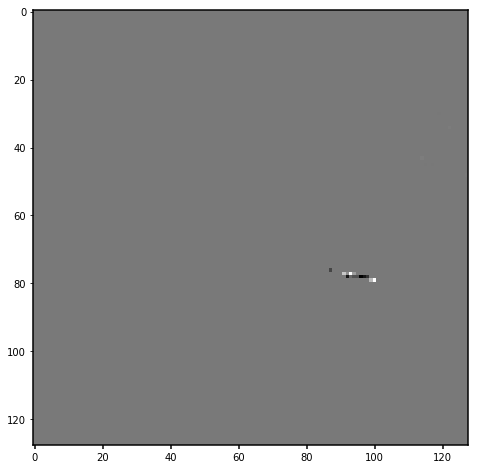

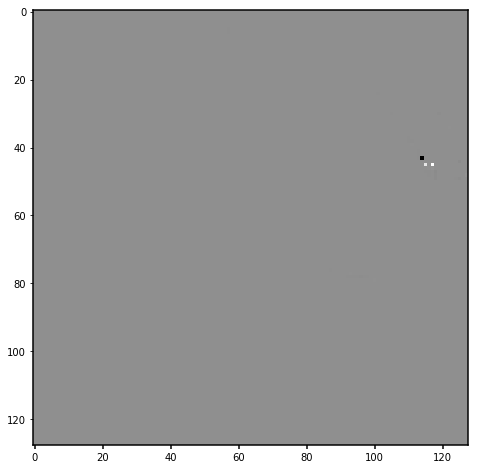

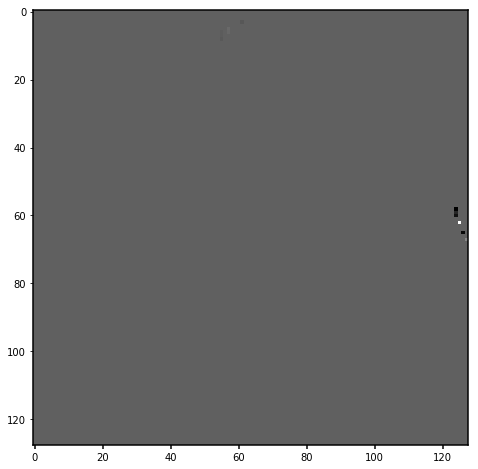

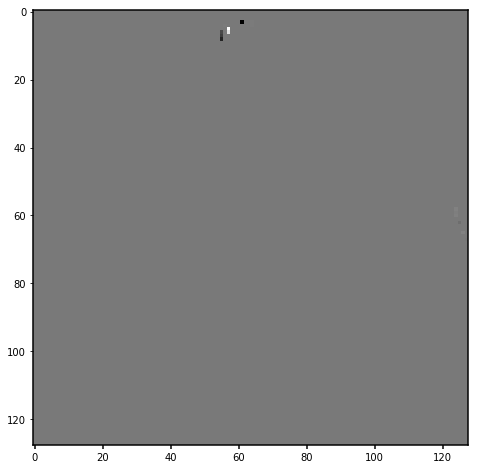

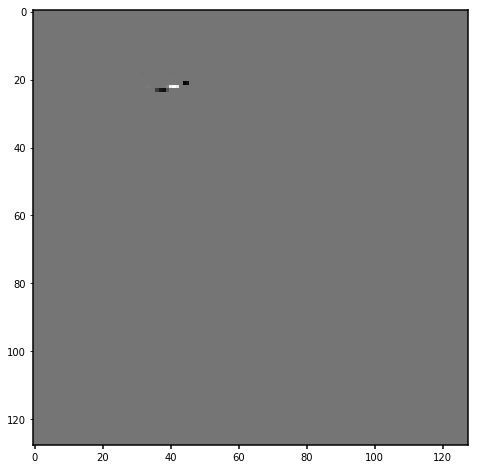

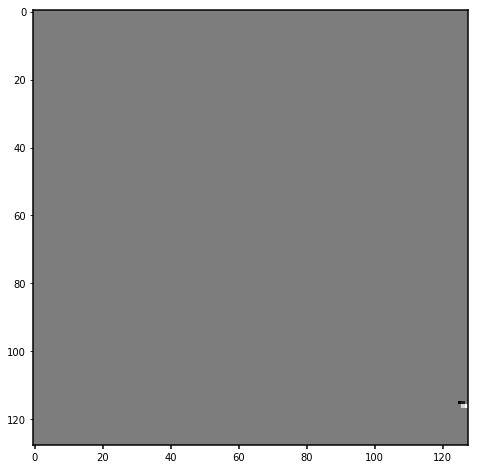

In [10]:

#Norm of each eigenvector
#print("Norm is "+str(np.linalg.norm(X[:,0])))

for i in np.arange(X.shape[1])[::-1]:
  figure(i)
  imshow(np.reshape(X[:,i],im.shape), interpolation='nearest', cmap=cm.gray)